# 2장 서울시 주요 공원 현황 분석

In [1]:
import sys
import numpy as np
import pandas as pd
import time
import json
import re

# A Fast, Extensible Progress Bar for Python and CLI
from tqdm import tqdm

# Statistical data visualization using matplotlib.
import seaborn as sns

# Python Data. Leaflet.js Maps.
import folium

# matplotlib: plotting with Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Set the matplotlib color cycle using a seaborn palette.
sns.set_palette('pastel')

# plot outputs appear and be stored within the notebook.
%matplotlib inline

# A module for finding, managing, and using fonts across platforms.
mpl.font_manager._rebuild()
sorted([f.name for f in mpl.font_manager.fontManager.ttflist if f.name.startswith('Malgun')])

# 폰트 설정
mpl.rc('font', family='Malgun Gothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# An importlib package installable from any python version
import importlib
import modules.fs as fs
import modules.juso as juso
import modules.kakao.map as kakao

## 서울시 행정구역 (구별) 통계

In [2]:
importlib.reload(fs)
area_seoul = fs.read_tsv('./data/area_in_seoul_2019.txt',
    names=[
        '기간', '구별', '구면적', '구성비(%)', 
        '행정동', '법정동', '통', '반'
    ],
    usecols=[
        '구별', '구면적'
    ],
    skiprows=[0,1,2],
    index_col='구별'
)

# Convert the base unit.
area_seoul['구면적'] = area_seoul['구면적'] * 1000

area_seoul.head()

,구면적
구별,
종로구,23910.0
중구,9960.0
용산구,21870.0
성동구,16860.0
광진구,17060.0


## 서울시 주민등록인구 (구별) 통계

In [3]:
importlib.reload(fs)
population = fs.read_tsv('./data/population_in_seoul_2019.txt',
    names=[
        '기간', '구별', '세대', 
        '인구', '남자', '여자', 
        '한국인', '한국인남자', '한국인여자',
        '등록외국인', '등록외국인남자', '등록외국인여자',
        '세대당인구', '65세이상고령자'
    ],
    usecols=[
        '구별', '세대', 
        '인구', '남자', '여자'
    ],
    skiprows=[0,1,2,3]
)

# Remove unnecessary data.
population.dropna(inplace=True)
population.set_index('구별', inplace=True)

population.head(1)

,세대,인구,남자,여자
구별,,,,
종로구,73947,161869,78215,83654


## 서울시 주요 공원현황

In [4]:
importlib.reload(fs)
major = fs.read_csv('./data/major_parks_in_seoul.csv', 
    encoding='euc-kr',
    names=[
        '공원번호', '공원명', '공원개요', '공원면적', 
        '개원일', '주요시설', '주요식물', '안내도', '오시는길', '이용시참고사항', '이미지', 
        '구별', '공원주소', '관리부서', '전화번호', 
        'X좌표(GRS80TM)', 'Y좌표(GRS80TM)', 
        'X좌표', 'Y좌표', 
        '바로가기'
    ],
    usecols=[
        '공원명', '공원면적',
        '구별', '공원주소', 
        'X좌표', 'Y좌표'
    ],
    skiprows=[0]
)

# Replace the default data value.
major['공원면적'] = major['공원면적'].replace(to_replace="([0-9]{4,})", value=r"\1 tmp", regex=True)
major['공원면적'] = major['공원면적'].replace(to_replace=" tmp.*", value="", regex=True)
major['공원면적'] = major['공원면적'].replace(to_replace="\w+\s+", value="", regex=True)
major['공원면적'] = np.where(major['공원명'] == '진관근린공원(구파발폭포)', np.nan, major['공원면적']) 
major['공원면적'] = pd.to_numeric(major['공원면적'])

# Remove unnecessary data.
major.set_index('구별', inplace=True)
major.dropna(inplace=True)
major.head()

,공원명,공원면적,공원주소,X좌표,Y좌표
구별,,,,,
중구,남산도시자연공원,2896887.0,서울특별시 중구 삼일대로 231(예장동),126.990377,37.550140
강동구,길동생태공원,80683.0,서울특별시 강동구 천호대로 1291(길동생태공원),127.154779,37.540394
과천시,서울대공원,9132690.0,경기도 과천시 대공원광장로 102,127.019847,37.426449
성동구,서울숲,480994.0,서울특별시 성동구 뚝섬로 273 (성수동1가),127.041798,37.543072
마포구,월드컵공원,2284085.0,서울특별시 마포구 하늘공원로 84(월드컵공원),126.878907,37.571805


## 서울시 공원 (1인당 공원면적) 통계

In [5]:
importlib.reload(fs)
area_parks = fs.read_tsv('./data/park_area_per_person_in_seoul_2019.txt', 
    names=[
        '기간', '구별', 
        '구공원면적', '1인당공원면적', 
        '도시공원면적', '1인당도시공원면적', 
        '생활권공원면적', '1인당생활권공원면적'
    ],
    usecols=[
        '구별', 
        '구공원면적', '1인당공원면적', 
        '도시공원면적', '1인당도시공원면적', 
        '생활권공원면적', '1인당생활권공원면적'
    ],
    skiprows=[0,1,2,3]
)

# Replace the default data value.
area_parks.replace(',', '', regex=True, inplace=True)
area_parks.replace('-', np.nan, regex=True, inplace=True)

# Converts a data type string to a number.
for column in area_parks.columns:
    if re.findall('기간|구별', column):
        continue
    area_parks[column] = pd.to_numeric(area_parks[column])

# Remove unnecessary data.
area_parks.dropna(inplace=True)
area_parks.set_index('구별', inplace=True)

area_parks.head(1)

,구공원면적,1인당공원면적,도시공원면적,1인당도시공원면적,생활권공원면적,1인당생활권공원면적
구별,,,,,,
종로구,11556.1,71.4,6433.0,39.7,3056.4,18.9


## 서울시 공원 통계

In [6]:
importlib.reload(fs)
parks = fs.read_tsv('./data/parks_in_seoul_2019.txt', 
    names=[
        '기간', '구별', 
        '공원수', '공원중복', '공원면적', 
        '자연공원', '자연공원중복', '자연공원면적', 
        '도시공원', '도시공원중복', '도시공원면적',
        '어린이공원', '어린이공원면적', 
        '소공원', '소공원면적', 
        '근린공원', '근린공원중복', '근린공원면적', 
        '도시자연공원', '도시자연공원중복', '도시자연공원면적', 
        '묘지공원', '묘지공원면적', 
        '문화공원', '문화공원면적', 
        '체육공원', '체육공원면적', 
        '역사공원', '역사공원면적', 
        '변공원', '변공원면적', 
        '생태공원', '생태공원면적', 
        '가로공원', '가로공원면적', 
        '기타공원', '기타공원중복', '기타공원면적'
    ],
    usecols=[
        '구별', 
        '공원수',
    ],
    skiprows=[0,1,2,3]
)

# Replace the default data value.
parks.replace(',', '', regex=True, inplace=True)
parks.replace('-', np.nan, regex=True, inplace=True)

# Converts a data type string to a number.
for column in parks.columns:
    if re.findall('기간|구별', column):
        continue
    parks[column] = pd.to_numeric(parks[column])

# Remove unnecessary data.
parks.set_index('구별', inplace=True)
parks.drop('서울대공원', inplace=True)
parks.dropna(inplace=True)

parks.head(1)

,공원수
구별,
종로구,106


## 서울시 공원 현황 차트

In [7]:
df = pd.merge(area_seoul, parks, on='구별')
df = pd.merge(df, area_parks, on='구별')
df = pd.merge(df, population, on='구별')
df = pd.merge(df, major, on='구별')
df.head(1)

,구면적,공원수,구공원면적,1인당공원면적,도시공원면적,1인당도시공원면적,생활권공원면적,1인당생활권공원면적,세대,인구,남자,여자,공원명,공원면적,공원주소,X좌표,Y좌표
구별,,,,,,,,,,,,,,,,,
종로구,23910.0,106,11556.1,71.4,6433.0,39.7,3056.4,18.9,73947,161869,78215,83654,광화문시민열린마당,8948.0,서울특별시 종로구 세종로 76-2,126.978023,37.575045


In [17]:
print(df.shape)
df.to_csv('./results/park.csv')
tmp = pd.read_csv('./results/park.csv')
tmp.head()

(126, 17)


,구별,구면적,공원수,구공원면적,1인당공원면적,도시공원면적,1인당도시공원면적,생활권공원면적,1인당생활권공원면적,세대,인구,남자,여자,공원명,공원면적,공원주소,X좌표,Y좌표
0,종로구,23910.0,106,11556.1,71.4,6433.0,39.7,3056.4,18.9,73947,161869,78215,83654,광화문시민열린마당,8948.0,서울특별시 종로구 세종로 76-2,126.978023,37.575045
1,종로구,23910.0,106,11556.1,71.4,6433.0,39.7,3056.4,18.9,73947,161869,78215,83654,낙산근린공원,201779.0,서울특별시 종로구 낙산길 41 (우) 03085,127.007587,37.580477
2,종로구,23910.0,106,11556.1,71.4,6433.0,39.7,3056.4,18.9,73947,161869,78215,83654,경희궁,98470.0,서울특별시 종로구 새문안로 55(신문로2가 2-1),126.968534,37.570773
3,종로구,23910.0,106,11556.1,71.4,6433.0,39.7,3056.4,18.9,73947,161869,78215,83654,탑골근린공원,19599.0,서울특별시 종로구 종로 99,126.988285,37.571005
4,종로구,23910.0,106,11556.1,71.4,6433.0,39.7,3056.4,18.9,73947,161869,78215,83654,마로니에공원,5802.0,서울특별시 종로구 대학로8길 1,127.002789,37.580230


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


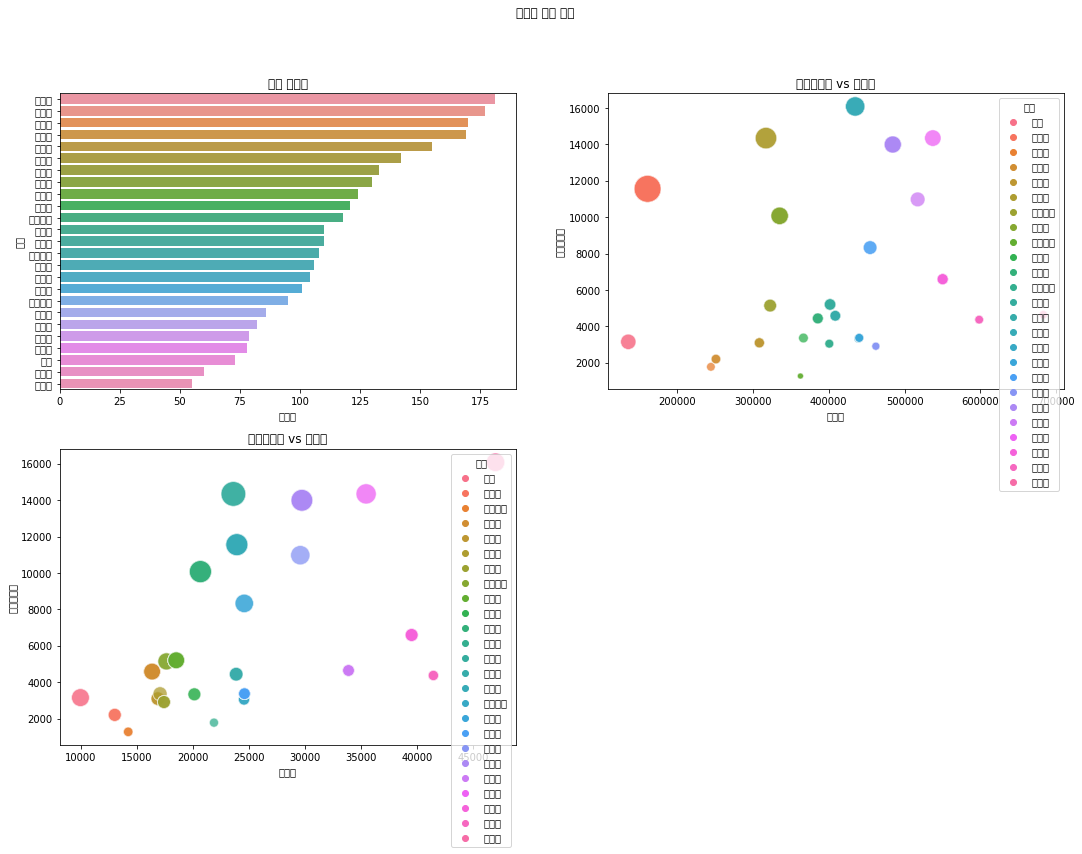

In [8]:
fig = plt.figure(figsize=(18, 12))
fig.suptitle('서울시 공원 현황')
fig.tight_layout()


# axis1
df1 = df.reset_index()
df1 = df1[['구별', '공원수']].sort_values(by='공원수', ascending=False)
plt.subplot(2,2,1)
plt.title('구별 공원수')
plt.xlabel('공원수')

sns.barplot(data=df1, x='공원수', y='구별', orient='h')


# axis2
df2 = df.reset_index()
df2 = df2[['구별', '인구', '구공원면적']].sort_values(by='인구', ascending=True)
df2_s = df2['구공원면적'] / df2['인구'] * 10000

plt.subplot(2,2,2)
plt.title('구공원면적 vs 구인구')
plt.xlabel('구인구')
plt.ylabel('구공원면적')

sns.scatterplot(data=df2, x='인구', y='구공원면적', hue='구별', s=df2_s, alpha=0.5)


# axis3
df3 = df.reset_index()
df3 = df3[['구별', '구면적', '구공원면적']].sort_values(by='구면적', ascending=True)
df3_s = df3['구공원면적'] / df3['구면적'] * 1000

plt.subplot(2,2,3)
plt.title('구공원면적 vs 구면적')
plt.xlabel('구면적')
plt.ylabel('구공원면적')

sns.scatterplot(data=df3, x='구면적', y='구공원면적', hue='구별', s=df3_s, alpha=0.5)

plt.show()

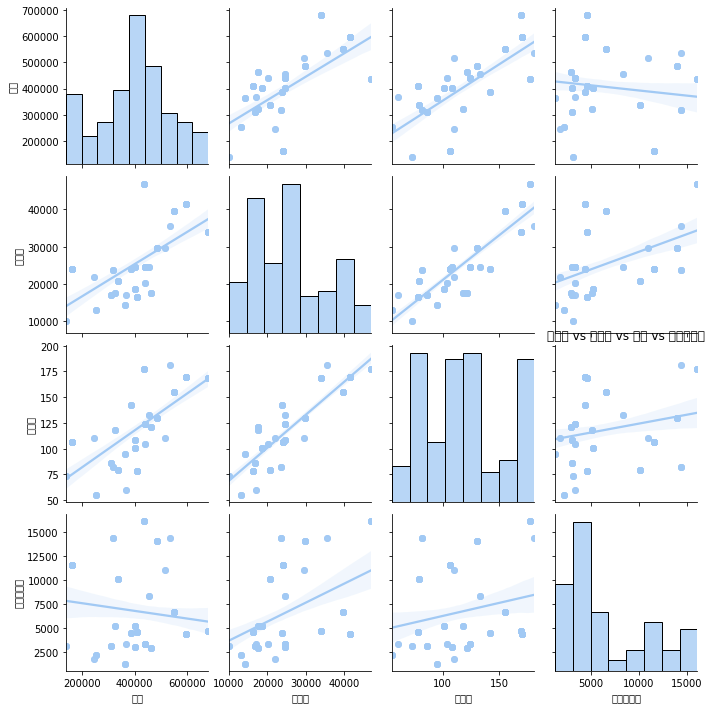

In [9]:
# axis5
df5 = df.reset_index()
df5 = df5[['구별', '인구', '구면적', '공원수', '구공원면적']].sort_values(by='구면적', ascending=True)

sns.pairplot(df5, vars=['인구', '구면적', '공원수', '구공원면적'], kind='reg')

plt.title('구인구 vs 구면적 vs 공원 vs 구공원면적')
plt.show()

## 공원 지도에 표시하기(공원 크기가 차이가 나도록)

In [10]:
geo_path = './data/SIG-seoul.json'
geo_data = json.load(open(geo_path, encoding='utf-8'))

In [11]:
data = df

map1 = folium.Map(
    location=[37.5502, 126.982], 
    tiles='cartodbpositron', # Stamen Toner, cartodbpositron
    zoom_start=11
)

for i in data.reset_index().index:

    html = """<div>
<h3 style="font-size:16px;font-weight:700;">{}</h3>
<p style="font-size:12px;">{}</p>
</div>""".format(data['공원명'][i], data['공원주소'][i])

    popup = folium.Popup(
        folium.IFrame(html, width=200, height=100), 
        max_width=200
    )

    folium.Marker(
        location=[data['Y좌표'][i], data['X좌표'][i]],
        popup=popup,
    ).add_to(map1)

map1

In [12]:
df.head(1)

,구면적,공원수,구공원면적,1인당공원면적,도시공원면적,1인당도시공원면적,생활권공원면적,1인당생활권공원면적,세대,인구,남자,여자,공원명,공원면적,공원주소,X좌표,Y좌표
구별,,,,,,,,,,,,,,,,,
종로구,23910.0,106,11556.1,71.4,6433.0,39.7,3056.4,18.9,73947,161869,78215,83654,광화문시민열린마당,8948.0,서울특별시 종로구 세종로 76-2,126.978023,37.575045


In [13]:
data = df

map1 = folium.Map(
    location=[37.5502, 126.982], 
    tiles='cartodbpositron', # Stamen Toner, cartodbpositron
    zoom_start=11
)

map1.choropleth(geo_data=geo_data, 
    data=data['공원수'], 
    columns=[data.index, data['공원수']], 
    fill_color='YlGn', # 'black', ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    key_on='properties.SIG_KOR_NM')

for i in data.reset_index().index:

    html = """<div>
<h3 style="font-size:16px;font-weight:700;">{}</h3>
<p style="font-size:12px;">{}</p>
</div>""".format(data['공원명'][i], data['공원주소'][i])

    popup = folium.Popup(
        folium.IFrame(html, width=200, height=100), 
        max_width=200
    )

    folium.CircleMarker(
        location=[data['Y좌표'][i], data['X좌표'][i]],
        popup=popup,
        radius=data['공원면적'][i] / 100000, 
        color='#3186cc', 
        fill_color='#3186cc'
    ).add_to(map1)

map1

## 강서구 지도에 공원 자세히 표시하기

In [14]:

# for i in data.index:
#     folium.CircleMarker(
#         [
#             data['Y좌표'][i],
#             data['X좌표'][i]
#         ], 
#         radius=data['공원'][i]/10, 
#         color='#3186cc', 
#         fill_color='#3186cc'
#     ).add_to(map1)
